Importação das Bibliotecas

In [16]:
import os
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import multiprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, 
    BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate,
    RandomContrast
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Esse código é para a utilização de todos os processadores

In [17]:
num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=num_cores,
                                  intra_op_parallelism_threads=num_cores)
tf.compat.v1.Session(config=config)


Inicialização das Variáveis que seram utilizadas dirante a execução do código

In [18]:
IMG_HEIGHT = 64
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 2

batch_size = 10
epochs = 15

Carrega os dados de treinamento

In [19]:
# Defina o diretório onde os arquivos foram salvos
# path = "/home/cristiano/Imagens/"
path = "/home/emanoelcepr/Imagens/"

diretorio_imagens =  path + "imagens_originais/Sentinel-2/treino_processadas/"

# Caminhos completos para os arquivos X_train.npy e Y_train.npy
X_train_file = os.path.join(diretorio_imagens, 'X_train.npy')
Y_train_file = os.path.join(diretorio_imagens, 'Y_train.npy')

# Carregar os dados de volta para o notebook
X_train = np.load(X_train_file)
Y_train = np.load(Y_train_file)

# Verificar a forma (shape) das arrays carregadas
print('Shape de X_train:', X_train.shape)
print('Shape de Y_train:', Y_train.shape)


Shape de X_train: (2122, 64, 64, 2)
Shape de Y_train: (2122, 64, 64, 1)


Estrutura da Rede U-Net

In [20]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

Cria e complita a rede

In [21]:
my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_unet.compile(optimizer=Adam(learning_rate=1e-4),  loss='binary_crossentropy', metrics=['accuracy'])

Visualização da estrutura criada

In [22]:
print(my_unet.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 64, 64, 64)           1216      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 64, 64, 64)           256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_18[0

Inicializa o treinamento e salva o resultado 

In [23]:
filepath = diretorio_imagens + "model70-30.h5"
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]
history = my_unet.fit(X_train, Y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

Epoch 1/15
170/170 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9662
Epoch 1: val_loss improved from inf to 0.28241, saving model to /home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5
170/170 [==============================] - 173s 994ms/step - loss: 0.2628 - accuracy: 0.9662 - val_loss: 0.2824 - val_accuracy: 0.9852
Epoch 2/15
170/170 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9961
Epoch 2: val_loss improved from 0.28241 to 0.14972, saving model to /home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5
170/170 [==============================] - 156s 916ms/step - loss: 0.1215 - accuracy: 0.9961 - val_loss: 0.1497 - val_accuracy: 0.9949
Epoch 3/15
170/170 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9976
Epoch 3: val_loss improved from 0.14972 to 0.08749, saving model to /home/emanoelcepr/Imagens/imagens_originais/Sentinel-2/treino_proc

Salva as métricas da rede já treinada

In [24]:
# Salvar o objeto 'history' 
history_file = diretorio_imagens + "history.pkl"
with open(history_file, 'wb') as file:
    pickle.dump(history.history, file)


In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Visualização dos Gráficos de Precisão e Perda

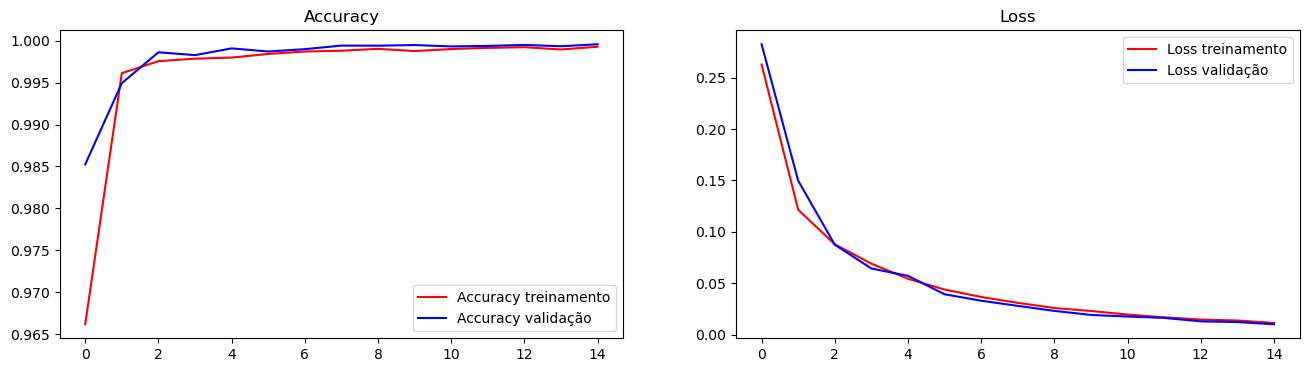

In [26]:
def mostrar_graficos(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label='Loss treinamento')
  plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
  plt.legend()
  plt.title('Loss')
  
  plt.show()

mostrar_graficos(history)